<a href="https://colab.research.google.com/github/Ianfm94/Financial_Analysis/blob/master/LSTM_Workings/1.%20Data_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)               1.0061
Variance (V)           0.0041

Monte Carlo Estimates
-----------------------------
Mean                   1.0097
Variance               0.0049
Standard deviation     0.0700
Skewness               3.1088
Excess kurtosis       26.1660

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound            1.0066
Upper bound            1.0127
Total running time: 3779.77 ms


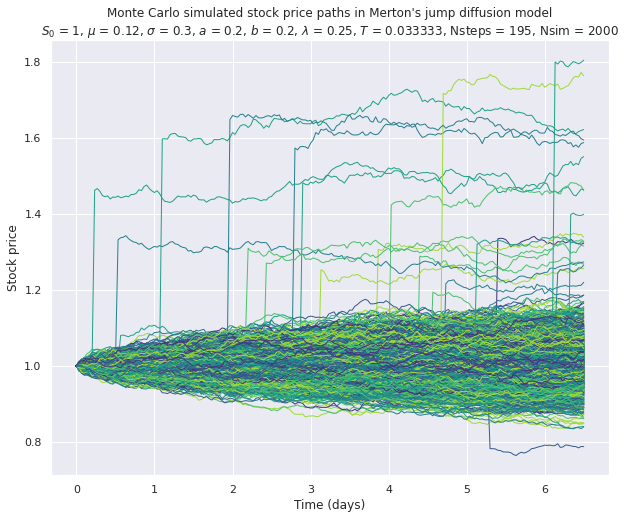

In [6]:
def jump_diffusion(S=1, X=0.5, T=0.033333, mu=0.12, sigma=0.3, Lambda=0.25,
                   a=0.2, b=0.2, Nsteps=195, Nsim=2000, alpha=0.05, seed=None):
    '''
    Monte Carlo simulation [1] of Merton's Jump Diffusion Model [2].
    The model is specified through the stochastic differential equation (SDE):
                        dS(t)
                        ----- = mu*dt + sigma*dW(t) + dJ(t)
                        S(t-)
    with:
    mu, sigma: constants, the drift and volatility coefficients of the stock
               price process;
    W: a standard one-dimensional Brownian motion;
    J: a jump process, independent of W, with piecewise constant sample paths.
       It is defined as the sum of multiplicative jumps Y(j).
    Input
    ---------------------------------------------------------------------------
    S: float. The current asset price.
    X: float. The strike price, i.e. the price at which the asset may be bought
       (call) or sold (put) in an option contract [3].
    T: int or float. The maturity of the option contract, i.e. the final
       monitoring date.
    mu, sigma: float. Respectively, the drift and volatility coefficients of
               the asset price process.
    Lambda: float. The intensity of the Poisson process in the jump diffusion
            model ('lambda' is a protected keyword in Python).
    a, b: float. Parameters required to calculate, respectively, the mean and
          variance of a standard lognormal distribution, log(x) ~ N(a, b**2).
          (see code).
    Nsteps: int. The number of monitoring dates, i.e. the time steps.
    Nsim: int. The number of Monte Carlo simulations (at least 10,000 required
          to generate stable results).
    alpha: float. The confidence interval significance level, in [0, 1].
    seed: int. Set random seed, for reproducibility of the results. Default
          value is None (the best seed available is used, but outcome will vary
          in each experiment).
    References
    ---------------------------------------------------------------------------
    [1] Glasserman, P. (2003): 'Monte Carlo Methods in Financial Engineering',
        Springer Applications of Mathematics, Vol. 53
    [2] Merton, R.C. (1976): 'Option Pricing when Underlying Stock Returns are
        Discontinuous', Journal of Financial Economics, 3:125-144.
    [3] Hull, J.C. (2017): 'Options, Futures, and Other Derivatives', 10th
        Edition, Pearson.
    '''

    # Import required libraries
    import time
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Set random seed
    np.random.seed(seed)

    '''
    Time the whole path-generating process, using a tic-toc method familiar
    to MATLAB users
    '''
    tic = time.time()

    # Calculate the length of the time step
    Delta_t = T/Nsteps

    '''
    Compute mean and variance of a standard lognormal distribution from user
    defined parameters a and b. The latter are useful to simulate the jump
    component in Monte Carlo.
    a and b are chosen such that log(Y(j)) ~ N(a, b**2). This implies that the
    mean and variance of the multiplicative jumps will be:
     * mean_Y = np.exp(a + 0.5*(b**2))
     * variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)
    '''
    mean_Y = np.exp(a + 0.5*(b**2))
    variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)

    '''
    Calculate the theoretical drift (M) and volatility (V) of the stock price
    process under Merton's jump diffusion model. These values can be used to
    monitor the rate of convergence of Monte Carlo estimates as the number of
    simulated experiments increases, and can help spot errors, if any, in
    implementing the model.
    '''
    M = S * np.exp(mu*T + Lambda*T*(mean_Y-1))
    V = S**2 * (np.exp((2*mu + sigma**2)*T \
        + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
        - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

    '''
    Generate an Nsim x (Nsteps+1) array of zeros to preallocate the simulated
    paths of the Monte Carlo simulation. Each row of the matrix represents a
    full, possible path for the stock, each column all values of the asset at
    a particular instant in time.
    '''
    simulated_paths = np.zeros([Nsim, Nsteps+1])

    # Replace the first column of the array with the vector of initial price S
    simulated_paths[:,0] = S

    '''
    To account for the multiple sources of uncertainty in the jump diffusion
    process, generate three arrays of random variables.
     - The first one is related to the standard Brownian motion, the component
       epsilon(0,1) in epsilon(0,1) * np.sqrt(dt);
     - The second and third ones model the jump, a compound Poisson process:
       the former (a Poisson process with intensity Lambda) causes the asset
       price to jump randomly (random timing); the latter (a Gaussian variable)
       defines both the direction (sign) and intensity (magnitude) of the jump.
    '''
    Z_1 = np.random.normal(size=[Nsim, Nsteps])
    Z_2 = np.random.normal(size=[Nsim, Nsteps])
    Poisson = np.random.poisson(Lambda*Delta_t, [Nsim, Nsteps])

    # Populate the matrix with Nsim randomly generated paths of length Nsteps
    for i in range(Nsteps):
        simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((mu
                               - sigma**2/2)*Delta_t + sigma*np.sqrt(Delta_t) \
                               * Z_1[:,i] + a*Poisson[:,i] \
                               + np.sqrt(b**2) * np.sqrt(Poisson[:,i]) \
                               * Z_2[:,i])

    # Single out array of simulated prices at maturity T
    final_prices = simulated_paths[:,-1]

    # Compute mean, variance, standard deviation, skewness, excess kurtosis
    mean_jump = np.mean(final_prices)
    var_jump = np.var(final_prices)
    std_jump = np.std(final_prices)
    skew_jump = stats.skew(final_prices)
    kurt_jump = stats.kurtosis(final_prices)

    # Calculate confidence interval for the mean
    ci_low = mean_jump - std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
    ci_high = mean_jump + std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)

    # Print statistics, align results
    print("Merton's Jump Diffusion Model")
    print('-----------------------------')
    print('Theoretical Moments')
    print('-----------------------------')
    print('Mean (M){:>21.4f}'.format(M))
    print('Variance (V){:>17.4f}'.format(V))
    print('\nMonte Carlo Estimates')
    print('-----------------------------')
    print('Mean {:>24.4f}'.format(mean_jump))
    print('Variance {:>20.4f}'.format(var_jump))
    print('Standard deviation {:>10.4f}'.format(std_jump))
    print('Skewness {:>20.4f}'.format(skew_jump))
    print('Excess kurtosis {:>13.4f}'.format(kurt_jump))
    print('\nConfidence interval, Mean')
    print('-----------------------------')
    print('Alpha {:>23.2f}'.format(alpha))
    print('Lower bound {:>17.4f}'.format(ci_low))
    print('Upper bound {:>17.4f}'.format(ci_high))

    # Choose palette, figure size, and define figure axes
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()

    # Generate t, the time variable on the abscissae
    t = np.linspace(0, T, Nsteps+1) * Nsteps

    # Plot the Monte Carlo simulated stock price paths
    jump_diffusion = ax.plot(t, simulated_paths.transpose());

    # Make drawn paths thinner by decreasing line width
    plt.setp(jump_diffusion, linewidth=1);

    # Set title (LaTeX notation) and x- and y- labels
    ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
$\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
           .format(S, mu, sigma, a, b, Lambda, T, Nsteps, Nsim), \
           xlabel='Time (days)', ylabel='Stock price')

    # Display figure in a Python environment
    #plt.show()
    plt.savefig('MC_Simulation_1.png')

    # Time and print the elapsed time
    toc = time.time()
    elapsed_time = toc - tic
    print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
    
    #from google.colab import  drive
    #drive.mount('/drive')
    pd.DataFrame(simulated_paths).to_csv("MC_Simulation_Prices_1.csv")

jump_diffusion()

Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)               1.0061
Variance (V)           0.0041

Monte Carlo Estimates
-----------------------------
Mean                   1.0047
Variance               0.0039
Standard deviation     0.0628
Skewness               1.6809
Excess kurtosis       13.0210

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound            1.0019
Upper bound            1.0074
Total running time: 3325.32 ms


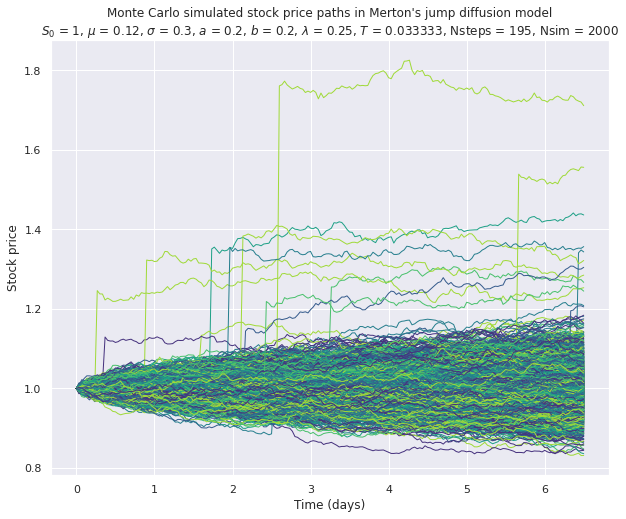

In [7]:
def jump_diffusion(S=1, X=0.5, T=0.033333, mu=0.12, sigma=0.3, Lambda=0.25,
                   a=0.2, b=0.2, Nsteps=195, Nsim=2000, alpha=0.05, seed=None):
    '''
    Monte Carlo simulation [1] of Merton's Jump Diffusion Model [2].
    The model is specified through the stochastic differential equation (SDE):
                        dS(t)
                        ----- = mu*dt + sigma*dW(t) + dJ(t)
                        S(t-)
    with:
    mu, sigma: constants, the drift and volatility coefficients of the stock
               price process;
    W: a standard one-dimensional Brownian motion;
    J: a jump process, independent of W, with piecewise constant sample paths.
       It is defined as the sum of multiplicative jumps Y(j).
    Input
    ---------------------------------------------------------------------------
    S: float. The current asset price.
    X: float. The strike price, i.e. the price at which the asset may be bought
       (call) or sold (put) in an option contract [3].
    T: int or float. The maturity of the option contract, i.e. the final
       monitoring date.
    mu, sigma: float. Respectively, the drift and volatility coefficients of
               the asset price process.
    Lambda: float. The intensity of the Poisson process in the jump diffusion
            model ('lambda' is a protected keyword in Python).
    a, b: float. Parameters required to calculate, respectively, the mean and
          variance of a standard lognormal distribution, log(x) ~ N(a, b**2).
          (see code).
    Nsteps: int. The number of monitoring dates, i.e. the time steps.
    Nsim: int. The number of Monte Carlo simulations (at least 10,000 required
          to generate stable results).
    alpha: float. The confidence interval significance level, in [0, 1].
    seed: int. Set random seed, for reproducibility of the results. Default
          value is None (the best seed available is used, but outcome will vary
          in each experiment).
    References
    ---------------------------------------------------------------------------
    [1] Glasserman, P. (2003): 'Monte Carlo Methods in Financial Engineering',
        Springer Applications of Mathematics, Vol. 53
    [2] Merton, R.C. (1976): 'Option Pricing when Underlying Stock Returns are
        Discontinuous', Journal of Financial Economics, 3:125-144.
    [3] Hull, J.C. (2017): 'Options, Futures, and Other Derivatives', 10th
        Edition, Pearson.
    '''

    # Import required libraries
    import time
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Set random seed
    np.random.seed(seed)

    '''
    Time the whole path-generating process, using a tic-toc method familiar
    to MATLAB users
    '''
    tic = time.time()

    # Calculate the length of the time step
    Delta_t = T/Nsteps

    '''
    Compute mean and variance of a standard lognormal distribution from user
    defined parameters a and b. The latter are useful to simulate the jump
    component in Monte Carlo.
    a and b are chosen such that log(Y(j)) ~ N(a, b**2). This implies that the
    mean and variance of the multiplicative jumps will be:
     * mean_Y = np.exp(a + 0.5*(b**2))
     * variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)
    '''
    mean_Y = np.exp(a + 0.5*(b**2))
    variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)

    '''
    Calculate the theoretical drift (M) and volatility (V) of the stock price
    process under Merton's jump diffusion model. These values can be used to
    monitor the rate of convergence of Monte Carlo estimates as the number of
    simulated experiments increases, and can help spot errors, if any, in
    implementing the model.
    '''
    M = S * np.exp(mu*T + Lambda*T*(mean_Y-1))
    V = S**2 * (np.exp((2*mu + sigma**2)*T \
        + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
        - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

    '''
    Generate an Nsim x (Nsteps+1) array of zeros to preallocate the simulated
    paths of the Monte Carlo simulation. Each row of the matrix represents a
    full, possible path for the stock, each column all values of the asset at
    a particular instant in time.
    '''
    simulated_paths = np.zeros([Nsim, Nsteps+1])

    # Replace the first column of the array with the vector of initial price S
    simulated_paths[:,0] = S

    '''
    To account for the multiple sources of uncertainty in the jump diffusion
    process, generate three arrays of random variables.
     - The first one is related to the standard Brownian motion, the component
       epsilon(0,1) in epsilon(0,1) * np.sqrt(dt);
     - The second and third ones model the jump, a compound Poisson process:
       the former (a Poisson process with intensity Lambda) causes the asset
       price to jump randomly (random timing); the latter (a Gaussian variable)
       defines both the direction (sign) and intensity (magnitude) of the jump.
    '''
    Z_1 = np.random.normal(size=[Nsim, Nsteps])
    Z_2 = np.random.normal(size=[Nsim, Nsteps])
    Poisson = np.random.poisson(Lambda*Delta_t, [Nsim, Nsteps])

    # Populate the matrix with Nsim randomly generated paths of length Nsteps
    for i in range(Nsteps):
        simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((mu
                               - sigma**2/2)*Delta_t + sigma*np.sqrt(Delta_t) \
                               * Z_1[:,i] + a*Poisson[:,i] \
                               + np.sqrt(b**2) * np.sqrt(Poisson[:,i]) \
                               * Z_2[:,i])

    # Single out array of simulated prices at maturity T
    final_prices = simulated_paths[:,-1]

    # Compute mean, variance, standard deviation, skewness, excess kurtosis
    mean_jump = np.mean(final_prices)
    var_jump = np.var(final_prices)
    std_jump = np.std(final_prices)
    skew_jump = stats.skew(final_prices)
    kurt_jump = stats.kurtosis(final_prices)

    # Calculate confidence interval for the mean
    ci_low = mean_jump - std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
    ci_high = mean_jump + std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)

    # Print statistics, align results
    print("Merton's Jump Diffusion Model")
    print('-----------------------------')
    print('Theoretical Moments')
    print('-----------------------------')
    print('Mean (M){:>21.4f}'.format(M))
    print('Variance (V){:>17.4f}'.format(V))
    print('\nMonte Carlo Estimates')
    print('-----------------------------')
    print('Mean {:>24.4f}'.format(mean_jump))
    print('Variance {:>20.4f}'.format(var_jump))
    print('Standard deviation {:>10.4f}'.format(std_jump))
    print('Skewness {:>20.4f}'.format(skew_jump))
    print('Excess kurtosis {:>13.4f}'.format(kurt_jump))
    print('\nConfidence interval, Mean')
    print('-----------------------------')
    print('Alpha {:>23.2f}'.format(alpha))
    print('Lower bound {:>17.4f}'.format(ci_low))
    print('Upper bound {:>17.4f}'.format(ci_high))

    # Choose palette, figure size, and define figure axes
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()

    # Generate t, the time variable on the abscissae
    t = np.linspace(0, T, Nsteps+1) * Nsteps

    # Plot the Monte Carlo simulated stock price paths
    jump_diffusion = ax.plot(t, simulated_paths.transpose());

    # Make drawn paths thinner by decreasing line width
    plt.setp(jump_diffusion, linewidth=1);

    # Set title (LaTeX notation) and x- and y- labels
    ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
$\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
           .format(S, mu, sigma, a, b, Lambda, T, Nsteps, Nsim), \
           xlabel='Time (days)', ylabel='Stock price')

    # Display figure in a Python environment
    #plt.show()
    plt.savefig('MC_Simulation_2.png')

    # Time and print the elapsed time
    toc = time.time()
    elapsed_time = toc - tic
    print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
    
    #from google.colab import  drive
    #drive.mount('/drive')
    pd.DataFrame(simulated_paths).to_csv("MC_Simulation_Prices_2.csv")

jump_diffusion()  


Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)               1.0047
Variance (V)           0.0041

Monte Carlo Estimates
-----------------------------
Mean                   1.0033
Variance               0.0036
Standard deviation     0.0598
Skewness               1.3958
Excess kurtosis       11.6370

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound            1.0006
Upper bound            1.0059
Total running time: 3413.22 ms


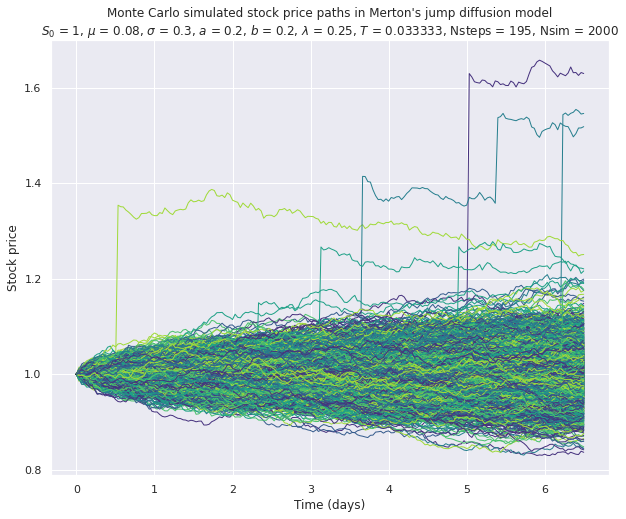

In [8]:
def jump_diffusion(S=1, X=0.5, T=0.033333, mu=0.08, sigma=0.3, Lambda=0.25,
                   a=0.2, b=0.2, Nsteps=195, Nsim=2000, alpha=0.05, seed=None):
    '''
    Monte Carlo simulation [1] of Merton's Jump Diffusion Model [2].
    The model is specified through the stochastic differential equation (SDE):
                        dS(t)
                        ----- = mu*dt + sigma*dW(t) + dJ(t)
                        S(t-)
    with:
    mu, sigma: constants, the drift and volatility coefficients of the stock
               price process;
    W: a standard one-dimensional Brownian motion;
    J: a jump process, independent of W, with piecewise constant sample paths.
       It is defined as the sum of multiplicative jumps Y(j).
    Input
    ---------------------------------------------------------------------------
    S: float. The current asset price.
    X: float. The strike price, i.e. the price at which the asset may be bought
       (call) or sold (put) in an option contract [3].
    T: int or float. The maturity of the option contract, i.e. the final
       monitoring date.
    mu, sigma: float. Respectively, the drift and volatility coefficients of
               the asset price process.
    Lambda: float. The intensity of the Poisson process in the jump diffusion
            model ('lambda' is a protected keyword in Python).
    a, b: float. Parameters required to calculate, respectively, the mean and
          variance of a standard lognormal distribution, log(x) ~ N(a, b**2).
          (see code).
    Nsteps: int. The number of monitoring dates, i.e. the time steps.
    Nsim: int. The number of Monte Carlo simulations (at least 10,000 required
          to generate stable results).
    alpha: float. The confidence interval significance level, in [0, 1].
    seed: int. Set random seed, for reproducibility of the results. Default
          value is None (the best seed available is used, but outcome will vary
          in each experiment).
    References
    ---------------------------------------------------------------------------
    [1] Glasserman, P. (2003): 'Monte Carlo Methods in Financial Engineering',
        Springer Applications of Mathematics, Vol. 53
    [2] Merton, R.C. (1976): 'Option Pricing when Underlying Stock Returns are
        Discontinuous', Journal of Financial Economics, 3:125-144.
    [3] Hull, J.C. (2017): 'Options, Futures, and Other Derivatives', 10th
        Edition, Pearson.
    '''

    # Import required libraries
    import time
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Set random seed
    np.random.seed(seed)

    '''
    Time the whole path-generating process, using a tic-toc method familiar
    to MATLAB users
    '''
    tic = time.time()

    # Calculate the length of the time step
    Delta_t = T/Nsteps

    '''
    Compute mean and variance of a standard lognormal distribution from user
    defined parameters a and b. The latter are useful to simulate the jump
    component in Monte Carlo.
    a and b are chosen such that log(Y(j)) ~ N(a, b**2). This implies that the
    mean and variance of the multiplicative jumps will be:
     * mean_Y = np.exp(a + 0.5*(b**2))
     * variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)
    '''
    mean_Y = np.exp(a + 0.5*(b**2))
    variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)

    '''
    Calculate the theoretical drift (M) and volatility (V) of the stock price
    process under Merton's jump diffusion model. These values can be used to
    monitor the rate of convergence of Monte Carlo estimates as the number of
    simulated experiments increases, and can help spot errors, if any, in
    implementing the model.
    '''
    M = S * np.exp(mu*T + Lambda*T*(mean_Y-1))
    V = S**2 * (np.exp((2*mu + sigma**2)*T \
        + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
        - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

    '''
    Generate an Nsim x (Nsteps+1) array of zeros to preallocate the simulated
    paths of the Monte Carlo simulation. Each row of the matrix represents a
    full, possible path for the stock, each column all values of the asset at
    a particular instant in time.
    '''
    simulated_paths = np.zeros([Nsim, Nsteps+1])

    # Replace the first column of the array with the vector of initial price S
    simulated_paths[:,0] = S

    '''
    To account for the multiple sources of uncertainty in the jump diffusion
    process, generate three arrays of random variables.
     - The first one is related to the standard Brownian motion, the component
       epsilon(0,1) in epsilon(0,1) * np.sqrt(dt);
     - The second and third ones model the jump, a compound Poisson process:
       the former (a Poisson process with intensity Lambda) causes the asset
       price to jump randomly (random timing); the latter (a Gaussian variable)
       defines both the direction (sign) and intensity (magnitude) of the jump.
    '''
    Z_1 = np.random.normal(size=[Nsim, Nsteps])
    Z_2 = np.random.normal(size=[Nsim, Nsteps])
    Poisson = np.random.poisson(Lambda*Delta_t, [Nsim, Nsteps])

    # Populate the matrix with Nsim randomly generated paths of length Nsteps
    for i in range(Nsteps):
        simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((mu
                               - sigma**2/2)*Delta_t + sigma*np.sqrt(Delta_t) \
                               * Z_1[:,i] + a*Poisson[:,i] \
                               + np.sqrt(b**2) * np.sqrt(Poisson[:,i]) \
                               * Z_2[:,i])

    # Single out array of simulated prices at maturity T
    final_prices = simulated_paths[:,-1]

    # Compute mean, variance, standard deviation, skewness, excess kurtosis
    mean_jump = np.mean(final_prices)
    var_jump = np.var(final_prices)
    std_jump = np.std(final_prices)
    skew_jump = stats.skew(final_prices)
    kurt_jump = stats.kurtosis(final_prices)

    # Calculate confidence interval for the mean
    ci_low = mean_jump - std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
    ci_high = mean_jump + std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)

    # Print statistics, align results
    print("Merton's Jump Diffusion Model")
    print('-----------------------------')
    print('Theoretical Moments')
    print('-----------------------------')
    print('Mean (M){:>21.4f}'.format(M))
    print('Variance (V){:>17.4f}'.format(V))
    print('\nMonte Carlo Estimates')
    print('-----------------------------')
    print('Mean {:>24.4f}'.format(mean_jump))
    print('Variance {:>20.4f}'.format(var_jump))
    print('Standard deviation {:>10.4f}'.format(std_jump))
    print('Skewness {:>20.4f}'.format(skew_jump))
    print('Excess kurtosis {:>13.4f}'.format(kurt_jump))
    print('\nConfidence interval, Mean')
    print('-----------------------------')
    print('Alpha {:>23.2f}'.format(alpha))
    print('Lower bound {:>17.4f}'.format(ci_low))
    print('Upper bound {:>17.4f}'.format(ci_high))

    # Choose palette, figure size, and define figure axes
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()

    # Generate t, the time variable on the abscissae
    t = np.linspace(0, T, Nsteps+1) * Nsteps

    # Plot the Monte Carlo simulated stock price paths
    jump_diffusion = ax.plot(t, simulated_paths.transpose());

    # Make drawn paths thinner by decreasing line width
    plt.setp(jump_diffusion, linewidth=1);

    # Set title (LaTeX notation) and x- and y- labels
    ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
$\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
           .format(S, mu, sigma, a, b, Lambda, T, Nsteps, Nsim), \
           xlabel='Time (days)', ylabel='Stock price')

    # Display figure in a Python environment
    #plt.show()
    plt.savefig('MC_Simulation_3.png')

    # Time and print the elapsed time
    toc = time.time()
    elapsed_time = toc - tic
    print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
    
    #from google.colab import  drive
    #drive.mount('/drive')
    pd.DataFrame(simulated_paths).to_csv("MC_Simulation_Prices_3.csv")

jump_diffusion()  


Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)               1.0037
Variance (V)           0.0095

Monte Carlo Estimates
-----------------------------
Mean                   0.9991
Variance               0.0090
Standard deviation     0.0946
Skewness               0.8344
Excess kurtosis        4.4195

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound            0.9949
Upper bound            1.0032
Total running time: 3582.99 ms


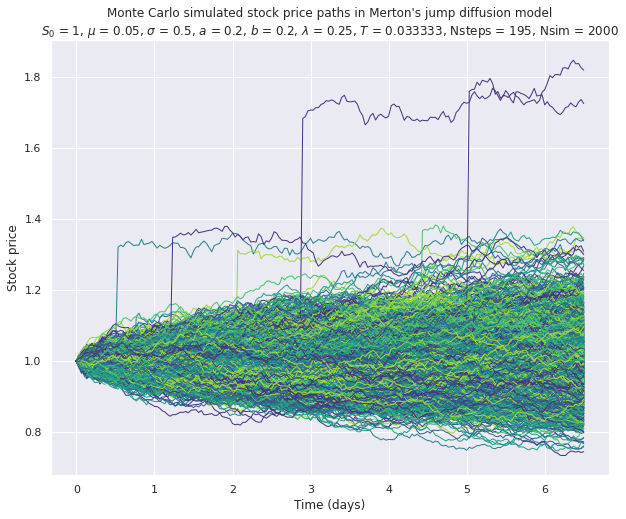

In [9]:
def jump_diffusion(S=1, X=0.5, T=0.033333, mu=0.05, sigma=0.5, Lambda=0.25,
                   a=0.2, b=0.2, Nsteps=195, Nsim=2000, alpha=0.05, seed=None):
    '''
    Monte Carlo simulation [1] of Merton's Jump Diffusion Model [2].
    The model is specified through the stochastic differential equation (SDE):
                        dS(t)
                        ----- = mu*dt + sigma*dW(t) + dJ(t)
                        S(t-)
    with:
    mu, sigma: constants, the drift and volatility coefficients of the stock
               price process;
    W: a standard one-dimensional Brownian motion;
    J: a jump process, independent of W, with piecewise constant sample paths.
       It is defined as the sum of multiplicative jumps Y(j).
    Input
    ---------------------------------------------------------------------------
    S: float. The current asset price.
    X: float. The strike price, i.e. the price at which the asset may be bought
       (call) or sold (put) in an option contract [3].
    T: int or float. The maturity of the option contract, i.e. the final
       monitoring date.
    mu, sigma: float. Respectively, the drift and volatility coefficients of
               the asset price process.
    Lambda: float. The intensity of the Poisson process in the jump diffusion
            model ('lambda' is a protected keyword in Python).
    a, b: float. Parameters required to calculate, respectively, the mean and
          variance of a standard lognormal distribution, log(x) ~ N(a, b**2).
          (see code).
    Nsteps: int. The number of monitoring dates, i.e. the time steps.
    Nsim: int. The number of Monte Carlo simulations (at least 10,000 required
          to generate stable results).
    alpha: float. The confidence interval significance level, in [0, 1].
    seed: int. Set random seed, for reproducibility of the results. Default
          value is None (the best seed available is used, but outcome will vary
          in each experiment).
    References
    ---------------------------------------------------------------------------
    [1] Glasserman, P. (2003): 'Monte Carlo Methods in Financial Engineering',
        Springer Applications of Mathematics, Vol. 53
    [2] Merton, R.C. (1976): 'Option Pricing when Underlying Stock Returns are
        Discontinuous', Journal of Financial Economics, 3:125-144.
    [3] Hull, J.C. (2017): 'Options, Futures, and Other Derivatives', 10th
        Edition, Pearson.
    '''

    # Import required libraries
    import time
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Set random seed
    np.random.seed(seed)

    '''
    Time the whole path-generating process, using a tic-toc method familiar
    to MATLAB users
    '''
    tic = time.time()

    # Calculate the length of the time step
    Delta_t = T/Nsteps

    '''
    Compute mean and variance of a standard lognormal distribution from user
    defined parameters a and b. The latter are useful to simulate the jump
    component in Monte Carlo.
    a and b are chosen such that log(Y(j)) ~ N(a, b**2). This implies that the
    mean and variance of the multiplicative jumps will be:
     * mean_Y = np.exp(a + 0.5*(b**2))
     * variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)
    '''
    mean_Y = np.exp(a + 0.5*(b**2))
    variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)

    '''
    Calculate the theoretical drift (M) and volatility (V) of the stock price
    process under Merton's jump diffusion model. These values can be used to
    monitor the rate of convergence of Monte Carlo estimates as the number of
    simulated experiments increases, and can help spot errors, if any, in
    implementing the model.
    '''
    M = S * np.exp(mu*T + Lambda*T*(mean_Y-1))
    V = S**2 * (np.exp((2*mu + sigma**2)*T \
        + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
        - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

    '''
    Generate an Nsim x (Nsteps+1) array of zeros to preallocate the simulated
    paths of the Monte Carlo simulation. Each row of the matrix represents a
    full, possible path for the stock, each column all values of the asset at
    a particular instant in time.
    '''
    simulated_paths = np.zeros([Nsim, Nsteps+1])

    # Replace the first column of the array with the vector of initial price S
    simulated_paths[:,0] = S

    '''
    To account for the multiple sources of uncertainty in the jump diffusion
    process, generate three arrays of random variables.
     - The first one is related to the standard Brownian motion, the component
       epsilon(0,1) in epsilon(0,1) * np.sqrt(dt);
     - The second and third ones model the jump, a compound Poisson process:
       the former (a Poisson process with intensity Lambda) causes the asset
       price to jump randomly (random timing); the latter (a Gaussian variable)
       defines both the direction (sign) and intensity (magnitude) of the jump.
    '''
    Z_1 = np.random.normal(size=[Nsim, Nsteps])
    Z_2 = np.random.normal(size=[Nsim, Nsteps])
    Poisson = np.random.poisson(Lambda*Delta_t, [Nsim, Nsteps])

    # Populate the matrix with Nsim randomly generated paths of length Nsteps
    for i in range(Nsteps):
        simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((mu
                               - sigma**2/2)*Delta_t + sigma*np.sqrt(Delta_t) \
                               * Z_1[:,i] + a*Poisson[:,i] \
                               + np.sqrt(b**2) * np.sqrt(Poisson[:,i]) \
                               * Z_2[:,i])

    # Single out array of simulated prices at maturity T
    final_prices = simulated_paths[:,-1]

    # Compute mean, variance, standard deviation, skewness, excess kurtosis
    mean_jump = np.mean(final_prices)
    var_jump = np.var(final_prices)
    std_jump = np.std(final_prices)
    skew_jump = stats.skew(final_prices)
    kurt_jump = stats.kurtosis(final_prices)

    # Calculate confidence interval for the mean
    ci_low = mean_jump - std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
    ci_high = mean_jump + std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)

    # Print statistics, align results
    print("Merton's Jump Diffusion Model")
    print('-----------------------------')
    print('Theoretical Moments')
    print('-----------------------------')
    print('Mean (M){:>21.4f}'.format(M))
    print('Variance (V){:>17.4f}'.format(V))
    print('\nMonte Carlo Estimates')
    print('-----------------------------')
    print('Mean {:>24.4f}'.format(mean_jump))
    print('Variance {:>20.4f}'.format(var_jump))
    print('Standard deviation {:>10.4f}'.format(std_jump))
    print('Skewness {:>20.4f}'.format(skew_jump))
    print('Excess kurtosis {:>13.4f}'.format(kurt_jump))
    print('\nConfidence interval, Mean')
    print('-----------------------------')
    print('Alpha {:>23.2f}'.format(alpha))
    print('Lower bound {:>17.4f}'.format(ci_low))
    print('Upper bound {:>17.4f}'.format(ci_high))

    # Choose palette, figure size, and define figure axes
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()

    # Generate t, the time variable on the abscissae
    t = np.linspace(0, T, Nsteps+1) * Nsteps

    # Plot the Monte Carlo simulated stock price paths
    jump_diffusion = ax.plot(t, simulated_paths.transpose());

    # Make drawn paths thinner by decreasing line width
    plt.setp(jump_diffusion, linewidth=1);

    # Set title (LaTeX notation) and x- and y- labels
    ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
$\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
           .format(S, mu, sigma, a, b, Lambda, T, Nsteps, Nsim), \
           xlabel='Time (days)', ylabel='Stock price')

    # Display figure in a Python environment
    #plt.show()
    plt.savefig('MC_Simulation_4.png')

    # Time and print the elapsed time
    toc = time.time()
    elapsed_time = toc - tic
    print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
    
    #from google.colab import  drive
    #drive.mount('/drive')
    pd.DataFrame(simulated_paths).to_csv("MC_Simulation_Prices_4.csv")

jump_diffusion()  


Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)               1.0121
Variance (V)           0.0065

Monte Carlo Estimates
-----------------------------
Mean                   1.0132
Variance               0.0061
Standard deviation     0.0780
Skewness               0.4850
Excess kurtosis        1.6249

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound            1.0098
Upper bound            1.0166
Total running time: 3613.79 ms


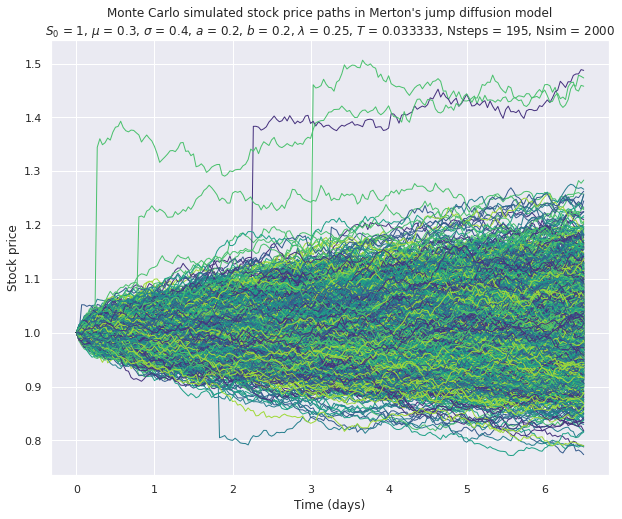

In [10]:
def jump_diffusion(S=1, X=0.5, T=0.033333, mu=0.3, sigma=0.4, Lambda=0.25,
                   a=0.2, b=0.2, Nsteps=195, Nsim=2000, alpha=0.05, seed=None):
    '''
    Monte Carlo simulation [1] of Merton's Jump Diffusion Model [2].
    The model is specified through the stochastic differential equation (SDE):
                        dS(t)
                        ----- = mu*dt + sigma*dW(t) + dJ(t)
                        S(t-)
    with:
    mu, sigma: constants, the drift and volatility coefficients of the stock
               price process;
    W: a standard one-dimensional Brownian motion;
    J: a jump process, independent of W, with piecewise constant sample paths.
       It is defined as the sum of multiplicative jumps Y(j).
    Input
    ---------------------------------------------------------------------------
    S: float. The current asset price.
    X: float. The strike price, i.e. the price at which the asset may be bought
       (call) or sold (put) in an option contract [3].
    T: int or float. The maturity of the option contract, i.e. the final
       monitoring date.
    mu, sigma: float. Respectively, the drift and volatility coefficients of
               the asset price process.
    Lambda: float. The intensity of the Poisson process in the jump diffusion
            model ('lambda' is a protected keyword in Python).
    a, b: float. Parameters required to calculate, respectively, the mean and
          variance of a standard lognormal distribution, log(x) ~ N(a, b**2).
          (see code).
    Nsteps: int. The number of monitoring dates, i.e. the time steps.
    Nsim: int. The number of Monte Carlo simulations (at least 10,000 required
          to generate stable results).
    alpha: float. The confidence interval significance level, in [0, 1].
    seed: int. Set random seed, for reproducibility of the results. Default
          value is None (the best seed available is used, but outcome will vary
          in each experiment).
    References
    ---------------------------------------------------------------------------
    [1] Glasserman, P. (2003): 'Monte Carlo Methods in Financial Engineering',
        Springer Applications of Mathematics, Vol. 53
    [2] Merton, R.C. (1976): 'Option Pricing when Underlying Stock Returns are
        Discontinuous', Journal of Financial Economics, 3:125-144.
    [3] Hull, J.C. (2017): 'Options, Futures, and Other Derivatives', 10th
        Edition, Pearson.
    '''

    # Import required libraries
    import time
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Set random seed
    np.random.seed(seed)

    '''
    Time the whole path-generating process, using a tic-toc method familiar
    to MATLAB users
    '''
    tic = time.time()

    # Calculate the length of the time step
    Delta_t = T/Nsteps

    '''
    Compute mean and variance of a standard lognormal distribution from user
    defined parameters a and b. The latter are useful to simulate the jump
    component in Monte Carlo.
    a and b are chosen such that log(Y(j)) ~ N(a, b**2). This implies that the
    mean and variance of the multiplicative jumps will be:
     * mean_Y = np.exp(a + 0.5*(b**2))
     * variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)
    '''
    mean_Y = np.exp(a + 0.5*(b**2))
    variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)

    '''
    Calculate the theoretical drift (M) and volatility (V) of the stock price
    process under Merton's jump diffusion model. These values can be used to
    monitor the rate of convergence of Monte Carlo estimates as the number of
    simulated experiments increases, and can help spot errors, if any, in
    implementing the model.
    '''
    M = S * np.exp(mu*T + Lambda*T*(mean_Y-1))
    V = S**2 * (np.exp((2*mu + sigma**2)*T \
        + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
        - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

    '''
    Generate an Nsim x (Nsteps+1) array of zeros to preallocate the simulated
    paths of the Monte Carlo simulation. Each row of the matrix represents a
    full, possible path for the stock, each column all values of the asset at
    a particular instant in time.
    '''
    simulated_paths = np.zeros([Nsim, Nsteps+1])

    # Replace the first column of the array with the vector of initial price S
    simulated_paths[:,0] = S

    '''
    To account for the multiple sources of uncertainty in the jump diffusion
    process, generate three arrays of random variables.
     - The first one is related to the standard Brownian motion, the component
       epsilon(0,1) in epsilon(0,1) * np.sqrt(dt);
     - The second and third ones model the jump, a compound Poisson process:
       the former (a Poisson process with intensity Lambda) causes the asset
       price to jump randomly (random timing); the latter (a Gaussian variable)
       defines both the direction (sign) and intensity (magnitude) of the jump.
    '''
    Z_1 = np.random.normal(size=[Nsim, Nsteps])
    Z_2 = np.random.normal(size=[Nsim, Nsteps])
    Poisson = np.random.poisson(Lambda*Delta_t, [Nsim, Nsteps])

    # Populate the matrix with Nsim randomly generated paths of length Nsteps
    for i in range(Nsteps):
        simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((mu
                               - sigma**2/2)*Delta_t + sigma*np.sqrt(Delta_t) \
                               * Z_1[:,i] + a*Poisson[:,i] \
                               + np.sqrt(b**2) * np.sqrt(Poisson[:,i]) \
                               * Z_2[:,i])

    # Single out array of simulated prices at maturity T
    final_prices = simulated_paths[:,-1]

    # Compute mean, variance, standard deviation, skewness, excess kurtosis
    mean_jump = np.mean(final_prices)
    var_jump = np.var(final_prices)
    std_jump = np.std(final_prices)
    skew_jump = stats.skew(final_prices)
    kurt_jump = stats.kurtosis(final_prices)

    # Calculate confidence interval for the mean
    ci_low = mean_jump - std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
    ci_high = mean_jump + std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)

    # Print statistics, align results
    print("Merton's Jump Diffusion Model")
    print('-----------------------------')
    print('Theoretical Moments')
    print('-----------------------------')
    print('Mean (M){:>21.4f}'.format(M))
    print('Variance (V){:>17.4f}'.format(V))
    print('\nMonte Carlo Estimates')
    print('-----------------------------')
    print('Mean {:>24.4f}'.format(mean_jump))
    print('Variance {:>20.4f}'.format(var_jump))
    print('Standard deviation {:>10.4f}'.format(std_jump))
    print('Skewness {:>20.4f}'.format(skew_jump))
    print('Excess kurtosis {:>13.4f}'.format(kurt_jump))
    print('\nConfidence interval, Mean')
    print('-----------------------------')
    print('Alpha {:>23.2f}'.format(alpha))
    print('Lower bound {:>17.4f}'.format(ci_low))
    print('Upper bound {:>17.4f}'.format(ci_high))

    # Choose palette, figure size, and define figure axes
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()

    # Generate t, the time variable on the abscissae
    t = np.linspace(0, T, Nsteps+1) * Nsteps

    # Plot the Monte Carlo simulated stock price paths
    jump_diffusion = ax.plot(t, simulated_paths.transpose());

    # Make drawn paths thinner by decreasing line width
    plt.setp(jump_diffusion, linewidth=1);

    # Set title (LaTeX notation) and x- and y- labels
    ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
$\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
           .format(S, mu, sigma, a, b, Lambda, T, Nsteps, Nsim), \
           xlabel='Time (days)', ylabel='Stock price')

    # Display figure in a Python environment
    #plt.show()
    plt.savefig('MC_Simulation_5.png')

    # Time and print the elapsed time
    toc = time.time()
    elapsed_time = toc - tic
    print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
    
    #from google.colab import  drive
    #drive.mount('/drive')
    pd.DataFrame(simulated_paths).to_csv("MC_Simulation_Prices_5.csv")

jump_diffusion()  
